# CNN and transfert learning: from MNIST to Devanagari

## Introduction

Hand written characters recognition is a popular challenge that has mutiple applications. From recognition of adresses on postals services to automatic reading for the visually impaires, this task has motivated a great number of researchers to find new ways of dealing with different kind of characters. For instance, digit recognition is one of the most studied version of this problem, and the MNIST database was used to get more than 99% of accuracy since the lates 90's (see http://yann.lecun.com/exdb/mnist/). 

Nowadays, techniques such as deep neural networks are sucessfully used on digits, the latin alphabet and chinese characters. We propose here to apply some of these techniques to the devanagari characters, used to write in India and Nepal.

However, if deep learning has been proven very helpful when the dataset is large (for instance on the MNIST, with a training set of 6000 examples per class), these techniques can be very challenging when the dataset is much smaller. Here, we choosed a dataset with approximately 200 examples by classes, and because we will want to split our dataset into a training, a validation and a testing dataset, we will end up with about 120 observations per classe.

Thus, this project will allow us to explore some useful techniques to apply when the training set is very small. We will demonstrate that these techniques allow us to achieve an accuracy between ... and ... (depending on the dataset), which is above the accuracy of both our benchmark model (a support vector classifier) and the model obtained by the author of this dataset (available here [insert link).

## Summary

1. Exploration and preprocessing of the dataset.
2. A simple benchmark model: Support vector classifier with whitening pre-processing.
3. A first approach with convolutionnal neural network.
4. Transfert learning from another hand written characters dataset.
5. Data augmentation applied to characters.



## Exploration and preprocessing of the dataset

### Loading and displaying the dataset
We will use a function defined in `load_data.py`, that returns the dataset as a list of PIL images and a list of labels.
This function can be used easily:

In [1]:
import load_data
from PIL import Image

In [2]:
consonants_img, consonants_labels = load_data.PIL_list_data('consonants')
vowels_img, vowels_labels = load_data.PIL_list_data('vowels')
numerals_img, numerals_labels = load_data.PIL_list_data('numerals')

Raw consonants loaded, 7380 obs of 36 classes
Raw vowels loaded, 2652 obs of 12 classes
Raw numerals loaded, 2880 obs of 10 classes



We then define a small function to easily display some charaters, randomly sampled from our dataset. We observe that the numerals are very similar to the Arab ones, but that the vowels and consonants seems more complicated and will likely be more difficult to classify. The thickness of the character is variable, but all characters are black on a white support. The images will likely need few pre-processing steps: they are already centered on the image, adjusted so they fill the entire space, and all the images have the same size and resolution. 

Some unprocessed numerals:


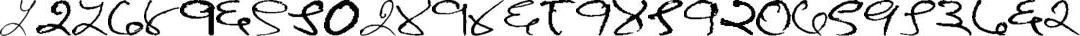

Some unprocessed vowels:


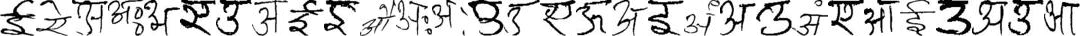

Some unprocessed consonants:


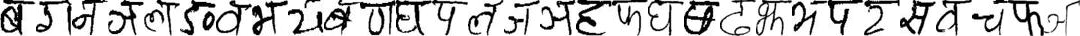

In [3]:
from IPython.display import display
from numpy import concatenate
from random import sample
from PIL import Image

def display_some(img_list, n=30, to_sample=True):
    if to_sample: 
        img_list = sample(img_list,n)
    display(Image.fromarray(concatenate(img_list,axis=1)))
    
print("Some unprocessed numerals:")
display_some(numerals_img)
print("Some unprocessed vowels:")
display_some(vowels_img)
print("Some unprocessed consonants:")
display_some(consonants_img)

### Preprocessing the images

Even if the images seems to be black and white, they are still RGB images. The first step is to convert these images to 'shades of greys' ones, reducing the dimension of the inputs from 36x36x3 to 36x36x1. A white pixel is represented by an integer value of 255, and a white one by a zero. Inverting the images, such as a stroke of the pen correpond to non-null values on the corresponding pixels usually leads to more stable results.

Some inverted numerals:


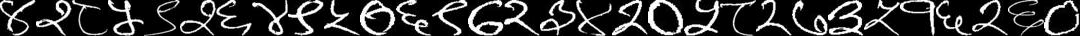

Some inverted vowels:


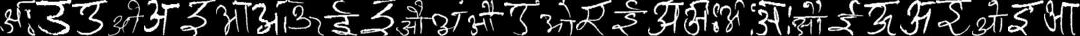

Some inverted consonants:


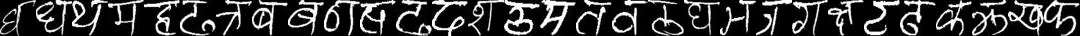

In [4]:
from PIL import ImageOps  

def pre_process(img_list):
    img_bw = [img.convert('LA') for img in img_list]
    return [ImageOps.invert(img) for img in img_list]

consonants_proc = pre_process(consonants_img)
vowels_proc = pre_process(vowels_img)
numerals_proc = pre_process(numerals_img)

print("Some inverted numerals:")
display_some(numerals_proc)
print("Some inverted vowels:")
display_some(vowels_proc)
print("Some inverted consonants:")
display_some(consonants_proc)

### Converting to tensors

In order to feed our images to a model, we need to convert them into vectors of a certain shape. The conversion is straight-forward: an image is represented as a superposition of channels (red, green and blue for instance), and each channel can be seen as a matrix of pixels activation. For instance, a red monochrome of 25 by 25 pixels will be represented by a matrix of shape `(25,25)` with all values set to the maximum for the red channel, and two null matrices of shape `(25,25)` for the blue and green channels.

Converting an image of size `l,p` to a matrice will then output a superposition of the three activation matrices (in the channel order Red, Blue, Green). Such an object is names a tensor, of shape `(l, p ,3)`. 

We work here with shades of grey images, so we only have one channel. As a result, an image of size `l,p` will be processed into a tensor of shape `(l, p, 1)`.

At last, we need to pass not one image but a set of images to our model. A set of `n` images can be seen as a list of tensor, which is also a tensor of shape `(n, l, p, 3)` for color images or `(n, l, p, 1)` for shades of grey ones.

The two following funtions allow us to transform `PIL` images into tensors:
- `ome_img_tensor` convert one image to a tensor of shape `(1, l, p, n_channel)` where `l` and `p` are the dimensions of the image and `n_channel` the number of channels (three for color images, one for shades of grey).
- `img_list_to_tensors` apply the function above to a list of images and return a tensor of shape `(n, l, p, n_channel)` where `n` is the length of the image list.

In [6]:
from keras.preprocessing import image
import numpy as np

def one_img_tensor(img):
    x = image.img_to_array(img)
    # 3D tensor to 4D tensor with shape (1, nb_pixel_x, nb_pixel_y, nchannel) for stacking
    return np.expand_dims(x, axis=0)

def img_list_to_tensors(img_list):
    list_of_tensors = [one_img_tensor(img) for img in img_list]
    ref_shape = list_of_tensors[0].shape
    assert all(tens.shape == ref_shape for tens in list_of_tensors)
    return np.vstack(list_of_tensors)


We can then transform our processed image lists to tensors. We specify a type to use for numerical computation (`float32`) and divide each value by 255 (the maximum activation possible), so that the values of our tensors are all between 0 and 1.

In [7]:
tensors_numerals = img_list_to_tensors(numerals_proc).astype('float32')/255.
tensors_vowels = img_list_to_tensors(vowels_proc).astype('float32')/255.
tensors_consonants = img_list_to_tensors(consonants_proc).astype('float32')/255.

## A simple benchmark model: Support vector classifier with whitening pre-processing.

It is a good idea to train a simple classifier on our dataset, be be able to assess the performance of a more sophisticated model. Here, we choose to use a support vector machine classifier (SVC) on the reduced features returned by a principal componant analysis (PCA). The SVC is well adapted when we have few samples (no more than 10000 points, and only 200 points per class here).

These classifiers have a lot of meta-parameters, but we will tune here only the C and gamma ones. We choose to use a gaussian kernel, the default one which works usually very well. We thus define a simple function that takes a vector of inputs and a vector of labels as arguments, test several sets of parameters, and return the best SVC found.
In order to do that, we use Scikit's GridSearch that will test all combinaisons of parameters from a dictionnary, compute an accuracy with a K-Fold, and return the best model.

The principal componant analysis (also called whitening) is very useful for some image recognition problems. To see why it works, the interested reader can take a look at the `Benchmark` notebook, detailing some theoretical explanations in addition to a visual exploration of the patterns uncovered by the PCA.

First, lets define a function that will take a list of images and their labels as an input, and return the best SVC found during the parameters tuning:

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def best_SVC(X,y):
    # Initiate a SVC classifier with default parameters
    svc_model = SVC()
    # The values to test for the C and gamma parameters.
    param_dic = {'C':[1,10,100],
                'gamma':[0.001,0.005,0.01,0.05]}
    clf = GridSearchCV(svc_model, param_dic, n_jobs=-1)
    # Search for the best set of parameters for our dataset, using bruteforce
    clf.fit(X, y)
    
    # We return the best model found
    return clf.best_estimator_

Then, we define another function that will take one of our three sets and its labels, and compute the accuracy of the best SVC found on a test set:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
    
def benchmark(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pca = PCA(n_components = 16)
    pca.fit(X_train)
    reduced_X_train, reduced_X_test = pca.transform(X_train), pca.transform(X_test)
    
    best_model = best_SVC(X_train,y_train)
    predictions = best_model.predict(X_test)
    return accuracy_score(y_test, predictions)

However, SVC can only take vectors as inputs, meaning we should convert our tensors of shape `(n, l, p, 1)` to a matrix of size `(n, l*p)`. The following function allows us to do so:

In [12]:
def tens2vec(tensor):
    n, l, p, n_channel = tensor.shape
    return np.reshape(tensor, (n, l*p*n_channel))

# Exemple : 
print("Shape of the input tensor: {}".format(tensors_numerals.shape))
print("Shape of the reshaped tensor: {}".format(tens2vec(tensors_numerals).shape))

Shape of the input tensor: (2880, 36, 36, 1)
Shape of the reshaped tensor: (2880, 1296)


We can then compute the accuracy of our benchmark model on the three sets:

In [17]:
score_on_numerals = benchmark(tens2vec(tensors_numerals), numerals_labels)
print("Best accuracy on numerals: {}".format(score_on_numerals))

score_on_vowels = benchmark(tens2vec(tensors_vowels), vowels_labels)
print("Best accuracy on vowels: {}".format(score_on_vowels))

score_on_consonants = benchmark(tens2vec(tensors_consonants), consonants_labels)
print("Best accuracy on consonants: {}".format(score_on_consonants))

Best accuracy on numerals: 0.969444444444
Best accuracy on vowels: 0.879336349925
Best accuracy on consonants: 0.749593495935



**On numerals, we achieve an accuracy of 97% on 10 classes**. Obviously, this result is far better than random guessing, and could be a better benchmark for a more sophisticated algorithm. 
As one can expect, the model is less accurate when the number of classes is growing: **only 88% on the vowels** (13 classes) and **75% on the consonants** (32 classes). From a human point of view, these characters also seems more complex than the numerals. As a result, a simple model like this on can perform well on character recognition if there is few classes and quite simple characters (like MNIST for instance). **Otherwise, we should use a more adapted model such as CNN**.

## A first approach with convolutionnal neural network

### Implementation details
**Convolutionnal neural networks (CNN)** are currently the state of the art in matter of image recognition. They have been proven one of the most efficient techniques during image classification challenges such as ***ImageNet***, where they dominated the competition. A lot of tools are nowaday available to create and train CNN. For instance, Google has made open source a deep-learning library, **Tensorflow**, which implement highly efficient optimization methods for artificial neural networks. More high-level frameworks, such as **Keras**, allows us to manipulate the Tensorflow back-end in a very user-friendly way.

Because the Keras-Tensorflow combinaison is fast to implement and highly efficient, we will use it in this project. We have chosen the **GPU version of Tensorflow** to train our models, using a **Nvidia GTX970m**. This combinaison allows us to train the following models in less than 5 minutes each.

### Building a model

Several categories of neural networks are available on Keras, such as recurrent neural networks (RNN) or graph models. **We will only use sequential models**, which are constructed by stacking several neural layers. These models are the simplest, but have been proven very capable in image recognition. For instance, ResNEt50 and VGG16/19 are sequential models that dominated ImageNet competitions.

#### Choosing layers

We have several types of layers than we can stack in our model, including:

- **Dense Layers**: The simplest layers, were all the weights are independant and the layer is fully connected to the previous and following ones. These layers works well at the top of the network, to analyse the high level features uncovered by the lower ones However, they tend to add a lot of parameters to our model and make it longer to train.
- **Convolutionnal layers**: The layers from which the CNN take its name. Convolutionnal layers works like small filters (with a size of often 3 or 4 pixels) that slide over the image (or the previous layer) and are activated when they find a special patter(such as straight lines, of angles). Convolutionnal layers can be composed of numerous filters that will learn to uncover different patterns. They offer translation invariance to our model, which is very useful for image classification. In addition to this, they have a reasonable (?) number of weights (usually very fewer than dense layers) and make the model faster to train compared to dense layers.
- **Pooling layers**: Pooling layers are useful when used with convolutionnal layers. They return the maximum activation of the neurons they take as inputs. Because of this, they allow us to easily reduce the output dimension of the convolutionnal layers. 
- **Dropout layers**: These layers are very different from the previous ones, as they only serve for the training and not the final model. Dropout layer will randomly "disconnect" neurons from the previous layer during training. Doing so is an efficient regularization technique that efficiently reduce overfitting (mode details below)

#### Compiling the model

Once our model built, we need to compile it before training. Compilation is done by specifying a loss, here the **categorical cross-entropy**, a metrics (**accuracy** is suitable for our case) and an optimization method. 
The loss is the objective function that the optimization method will minimize. Cross-entropy is a very popular choice for classification problems because it is differentiable, and because reducing the cross-entropy lead to a better accuracy. Choosing accuracy as our performance metric is fair because our classes are well balanced in our dataset.
At last, we use the **root mean square propagation (RMSprop)** as an optimization method. This method is a variant from the classic gradient descent method, that will adapt the learning rate for each weight. This optimizer allows us to tune the **learning rate**, as we observed that a smaller learning rate leads to better final results, even if the number of epoches needed for the training increase.

With all these tools, we define a first model for the consonants dataset (models for the vowels and numerals dataset are small variants and are proposed at the end of the document). This model is meant to be trained from scratch **without transfer learning or data-augmentation**, in order to allow us to quantify the improvements brought by these techniques.

#### A model to train from scratch for the consonants

We try several models, but this one has provided the best results. The motivation for its construction is the following:

- We start by a **two-dimension convolutionnal layer**(because our images only have one channel). We specify the number of filters wanted for this layer. 32 seems like a good compromise between complexity and performance. Putting **32 filters** in this layer means that this layer will be able to identify up to 32 different patterns. It is worth noting that raising this number to 64 doesn't improve the overall performance, but doesn't make the model notably harder to train either. We specify a kernel size: 3 pixels by 3 pixels seems like a correct size, as it is enough to uncover simple patterns like straight lines or angles, but not to big given the size of our imputs (only 36x36 pixels, the input shape). At last, we specify an activation function for this layer. We will use **rectified linear units (ReLU)**, as they efficiently tackle the issue of the vanishing gradient.
- We then add another **convolutionnal layer**, to uncover more complicated patterns, this time with **64 filters** (as we expect that more complicated patters than simple patterns will emmerge from our dataset). We keep the same kernel size and the same activation function.
- After that, we add a **max-pooling layer** to reduce the dimensionality of our inputs. The pooling layer has no weights or activation function, and will output the biggest value found in its kernel. We choose a **kernel size of 2 by 2**, to loose as little informations as possible while reducing the dimension.
- After that pooling layer, we add a first **dense layer with 256 nodes** to analyse the patterns uncovered by the convolutionnal layers. Being fully connected to the previous layer and the following dense one, the size of this layer will have a huge impact on the total number of trainable parameters of our model. Because of that, we try to keep this layer reasonably small, while keeping it large enough to fit the complexity of our dataset. Because we only have **36 classes** and because our images are not really complex (shades of gray strokes of a pencil), we choose a size of 256 nodes for this layer. We add a ReLU activation function, as we did in the previous layers.
- At last, we add the **final dense layer**, with **one node for each class** (36 for the consonant dataset). Each node of this layer should output a probability for our image to belong to one of the classes. Because of that, we want our activation function to return values between 0 and 1, and thus choose a **softmax activation function** instead of a ReLU as before.

#### Overfitting

Because of their complexity and their large number of weights, **neural networks are very prone** to overfitting. Overfitting can be observed when the accuracy on the training set is really high, but the accuracy on the validation set is much poorer. This phenomenon occures when the model have learnt "by heart" the training observations but is no longer capable of generalizing its prediction to new observations. As a result, we should stop the training of our model when the accuracy on the validation set is no longer decreasing. Keras allows us to easily do that by saving the weights at each iteration, and only if the validation score decrease.

However, if our model overfit too quick, this method will stop the training too soon and the model will yield very poor results on the validation and testing set. To counter that, we will use a **regularisation method**, preventing overfitting while allowing our model to perform enough iterations during the learning phase to be efficient. 

The method we will use relies on **dropout layers**. Dropout layers are layers that will randomly "disconnect" neurons from the previous layer, meaning their activation for this training iteration will be null. By disconnecting different neurons at random, we prevent the neural network to build too specific structures that are only useful to learn the training observations and not the concept behing them.

To apply this method, **we insert two drop_out layers in our model**, before each dense layer. Drop_out layers require only one parameter: the probability of a neuron to be disconnected during a training iteration. These parameters should be adjusted with trials and errors, by monitoring the accuracy on the testing and validation set during training. We found that **25% for the first drop_out layer and 80% for the second** give the best results.

The corresponding model, built with Keras, is as followed:

In [39]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(36, activation='softmax'))

model.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 34, 34, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
__________

### Training the model


#### Splitting the dataset into a training and a testing set.

Evaluation the performances of a model can be done as followed:

- We split our dataset (and the corresponding labels) into a training set and testing set. The training set can used as we wish to train our model, and the performances of our model will tested thanks to the test set. Because of that, the test set can be seen as "real world" samples of images that we didnt had when we trained our model, but for which we want to make predictions.

#### What about a validation set ?

When training our model, we will want to be able to monitor its performances on observations that we didn't used for fitting the model, in order to detect overfitting or know when to stop the learning. Because of that, our training set will be further divided into a 'real' training set, that is the one we will use for gradient descent, and a validation set that we will use to monitor the performances during training.

#### Should we use the test set as a validation set ?

Splitting our dataset another time to get a validation set has obvious drawbacks: we will again reduce the number of observations used for actual training. In some sense, the performances on the testing set and the validation set should not differ a lot, as the model has never used any of these sets for learning.

However, it can be spurious to use the same set of observations as a validation and testing set:

- Because we select our model based on the performance on the valiation set (by stopping the learning earlier or choosing hyper-parameters), we will artificially enhance the performance of the model on this set.
- If our model has a great number of hyper-parameters (parameters not actually learnt from the training set but choosed by the engineer), it is possible to overfit the validation set. Consider the following case: We decide that the weights of our neural network will not be adjusted by gradient descent, but will be fixed from the beginning to a random value (considering these weights as hyper-parameters). The model will in fact be unable to learn from the training set. However, if we decide to run the training/validation procedure multiple times, like we would do during a grid-search, we could eventually get a fair performance on the validation set (due to a lucky pick of values for the weights). Such a model would have over-fitted the validation set and will have poor performance on the testing set. This case is extrem and very unlikely for a neural network (as weights are usually not considerated as hyper-parameters), but has been experienced in real word situations for other models. For instance, the leaderboad on Kaggle can be seen as a validation set, while the real testing set is kept secret until the end of the competiton: competitors with a lot of submissions sometime manage to [overfit the leaderboard](http://blog.kaggle.com/2012/07/06/the-dangers-of-overfitting-psychopathy-post-mortem/).

Using the same set as a testing and validation set is sometime done and accepted by the community. In fact, the tutorial provided by Keras for learning the MNIST database [do so](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py), while being approved as an official example in the Keras Github repository.

However, we believe that splitting the dataset into a training, a validation and a testing set is the most rigorous way to do machine learning, even if the drawbacks (loosing observations to train) seems important given that the performances on the validation and testing sets are almost identical. For that reason, we will split our dataset in three.

#### How to split the dataset

The first thing to do is to choose the proportions of samples that we want in our three sets. Putting few observations in the testing and validation set will lead to a poor estimation of our model's performances. However, putting more observations in those sets will lead to a smaller training set, meaning our model will lean on fewer examples and will be less accurate. We then have to make a compromise to choose these proportions.

We choosed to divide our dataset according to the following:
- Training set: **70%**
- Validation set: **15%**
- Testing set: **15%**

At last, when splitting our dataset, we should make sure that the classes remain equally balanced into our three sets. This can be done easily with `sklearn train_test_split` function, by using the `stratify` parameter. 

#### Implementation

We will implement a `get_score` function that will take as inputs the following:
- ***tensors***: A whole dataset as a tensor
- ***labels***: The corresponding labels
- ***model***: The untrained Keras model for which we want to compute the accuracy
- ***epoch***: An integer specifying the number of epoch for training
- ***batch_size***: An integer, the size of a batch for learning (the greater the better, if the memory allows it)
- ***name***: The name of the model (to save the weights
- ***verbose***: An optionnal bolean (default is false) that determines if we should tell Keras to display informations during the training (useful for experimentation, but set to false in the final version to manage space on the notebook)

The function will do the following:
- Perform one-hot encoding on the labels, so they can be understood by the model.
- Split our dataset into a training, a validation and a testing set as detailed above.
- Create a checkpointer which allows us to save the weights during training (only if the accuracy is still improving).
- Fit the model on the testing set and monitor its performances on the validation set (to know when to save weights).
- Compute and print the accuracy on the testing set.
- Return the trained model with the best weights availables.

The implementation of this function can be seen below:


In [40]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint  
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

def get_score(tensors, labels, model, epoch, batch_size, name, verbose=False):
    
    nb_labels = len(set(labels)) #Get the number of disctinct labels in the dataset
    # Encode the labels (integers) into one-hot vectors
    y_all = np_utils.to_categorical([i-1 for i in np.array(labels).astype(int)], nb_labels)
    # Split the testing set from the whole set, with stratification
    X_model, X_test, y_model, y_test = train_test_split(tensors, y_all,
                                        test_size=0.15, stratify=y_all, random_state=1)
    # Then split the remaining set into a training and a validation set
    # We use a test size of 17.6% because our remaining set account for only 85% of the whole set
    X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, 
                                        test_size=0.176, stratify=y_model, random_state=1)
    # Display the sizes of the three sets
    print("Size of the training set: {}".format(len(X_train)))
    print("Size of the validation set: {}".format(len(X_val)))
    print("Size of the testing set: {}".format(len(X_test)))
    
    # Create a checkpointer to save the weights when the validation loss decrease
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.{}.hdf5'.format(name), 
                               verbose=1, save_best_only=True)
    # Fit the model, using 'verbose'=1 if we specified 'verbose=True' when calling the function (0 else)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpointer],
             batch_size=batch_size, epochs=epoch, verbose=(1 if verbose else 0))
    
    # Reload best weights before prediction, and predict
    model.load_weights('saved_models/weights.best.{}.hdf5'.format(name))
    y_pred = model.predict(X_test)
    
    # Compute and print the accuracy
    print("Accuracy on test set: {}".format(
            accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))
    
    return model # And return the trained model

    

We can now get a score for the model we built above. Because we want to save some space on this notebook, the model was trained a first time, the weights saved, and we called the function a last time with only three epochs (to display only three learning steps). In other words, if we want to perform 40 epochs, we will call the function a first time with 37 epochs (and verbose=True), and a last time with 3 epochs to clean the cell a little bit. For clarity, we will write that the function was called with 40 epochs in the python cell (so that one can have the same result when running the notebook, just uglier). It is worth noting that these methods are equivalent because we freezed the random seed in the `train_test_split` function (so the training, valiation and testing set are always the sames when the function is called).

In [47]:
get_score(tensors_consonants, consonants_labels, model, epoch=180, batch_size=800, name='consonants_from_scratch')

Size of the training set: 5168
Size of the validation set: 1105
Size of the testing set: 1107
Epoch 00000: val_loss improved from inf to 0.37672, saving model to saved_models/weights.best.consonants_from_scratch.hdf5
Epoch 00001: val_loss improved from 0.37672 to 0.35706, saving model to saved_models/weights.best.consonants_from_scratch.hdf5
Epoch 00002: val_loss improved from 0.35706 to 0.33636, saving model to saved_models/weights.best.consonants_from_scratch.hdf5
Accuracy on test set: 0.859078590786


### Results

We achieve an accuracy of **85,9%** on the testing set for the consonants, which is better than what we obtained with the SVC. The models for the vowels and the numerals can be find at the end of the notebook, but their performances are reported below:

|            | CNN from scratch | SVC with PCA |
|------------|:---------------:|:------------:|
| Numerals   |      97.9%      |        96.9% |
| Vowels     |      93.5%      |        87.9% |
| Consonants |      85.9%      |        75.0% |


We observe that a CNN beats our benchmark on the three datasets.

We can now try to improve these results with a new method, called transfer learing.

## Transfer learning:

### What is transfer learning

Transfer learning is the art of using what a model learnt on some problem to solve a new one. In image recognition, transfer learning is very popular and produce amazing results, especially when the dataset is small. The idea behing applying transfer learning in image recognition is the following: if a CNN has learnt to extract features when classifying a huge set of images, then these features are probably relevant for other classification problems. 

Transfer learning has the following interesting advantages:
- Training a large model take a lot of resources. By using an already trained model, we can save hours of computation.
- Models used for transfer learning are usually trained on huges datasets. For instance, the models availables in Keras (such as InceptionV3, VGG16/19, ResNet50, etc...) are trained on imageNet over millions of images and more than 1000 classes. Because of the complexity of the classification they had to perform during training, they learnt how to extract some really specific features. For any new classification problem, it is very likely that some of these features will be very helpful.
- When the dataset we have is too small, there is a good chance that the model will not be able to learn how to extract useful features. Using already-trained convolutionnal layers will allow the model to work out how to use the features instead of how to extract them, which is more relevant and usually simpler.

A classic transfer learning method consists in using already trained convolutionnal layers to extract features, and to only train the last dense layers of the model using our dataset.

### How to apply it for character recognition

#### About using Keras' available models (trained on imageNet)

To apply this method for our character recognition problem, we need to find a suitable already trained model. We can't use the models trained on imageNet for the following reasons:
- These models are trained to recognize object (and some shapes or concepts), but character recognition is a very different task. A CNN generally classifies an object by extracting very specific descriptors (such as eyes, furr, beaks, etc...) only found in this object. Character recognition is different because there is no distinctable patterns to extract (only stokes of a pen).
- Character recognition is simple (if we have enough data) than general image recognition, thus a simpler model can achieve strong results. Using a model suitable for imageNet on our problem would be an "overkill", wasting computationnal ressources by trying to extract irrelevant patterns.
- Models trained on imageNet take colored images as inputs, but our images are black and white. This is not a real problem since we could consider our images as colored, but using three channels instead of one would be again a waste of resources.
- At last but not least, these models have a minimum input size, generally above 100 by 100 pixels, whereas our images are only 36 by 36 pixels.

#### Using MNIST to pre-train a model

In order to perform transfer learning, and because we can't use imageNet models, we will train a model on a quite similar problem, but for which we have a much bigger dataset.
We will then use the MNIST database, which consists of hand written digits, and has 60 000 images in the training set. We will train a CNN on this database, and use the resulting convolutionnal layers in a new model for the devanagari characters.

### Pre-training on MNIST Database

#### Loading the database

We load the MNIST database, reshape the images and rescale them as we did for the devanagari characters.
We also convert the labels into one-hot arrays as before:

In [63]:
from keras.datasets import mnist

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_train_mnist = X_train_mnist.reshape(X_train_mnist.shape[0], 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(X_test_mnist.shape[0], 28, 28, 1)

X_train_mnist = X_train_mnist.astype('float32')/255.
X_test_mnist = X_test_mnist.astype('float32')/255.

y_train_mnist, y_test_mnist = np_utils.to_categorical(y_train_mnist),  np_utils.to_categorical(y_test_mnist)

We then define a sequential model to be trained on the MNIST database. The layers used have already been described before in the first part of the notebook. The architecture is quite similar to what we have done before, except that because we have more training images, we can now afford a more complex model. Because of that, we add another convolutonnal layer, to a total of three. We change the input size to match the dimensions of the MNIST images (28 by 28 pixels). It is worth noting that the weights of convilutionnal layers does not depend on the size of the input. Thus, we will be able to transfer the convolutionnal layers event if the dimension of the devanagari characters images is not the same.

The model trained on the MNIST database is the following:

In [65]:
model_mnist = Sequential()
model_mnist.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_mnist.add(Conv2D(32, (3, 3), activation='relu'))
model_mnist.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist.add(Conv2D(32, (4, 4), activation='relu'))
model_mnist.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist.add(Dropout(0.25))
model_mnist.add(Flatten())
model_mnist.add(Dense(256, activation='relu'))
model_mnist.add(Dropout(0.5))
model_mnist.add(Dense(10, activation='softmax'))

model_mnist.summary()
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_mnist.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
__________

We can now train the model. Because our goal is to perform transfer learning, we are not interested in measuring very accurately the performances of this model. Thus, we will use the testing set as a validation set.

The previous model achieve an accuracy of 99.46% on the validation set.

In [68]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mnist.hdf5', 
                               verbose=1, save_best_only=True)
model_mnist.fit(X_train_mnist, y_train_mnist, validation_data=(X_test_mnist, y_test_mnist), callbacks=[checkpointer],
         batch_size=256, epochs=36)

model_mnist.load_weights('saved_models/weights.best.mnist.hdf5')

y_pred_mnist = model_mnist.predict(X_test_mnist)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test_mnist,axis=1), np.argmax(y_pred_mnist,axis=1))))

Epoch 00000: val_loss improved from inf to 0.01860, saving model to saved_models/weights.best.mnist.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.01860 to 0.01838, saving model to saved_models/weights.best.mnist.hdf5
Accuracy on test set: 0.9946


We remove the last layers of this model, in order to save only the weights of the convolutionnal layers:

In [76]:
for i in range(5): # We remove the five last layers
    model_mnist.pop()
    
model_mnist.summary() # Display the layers left
model_mnist.save_weights('saved_models/weights.conv_layer.mnist.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 32)          0         
Total params: 35,520
Trainable params: 35,520
Non-trainable params: 0
_________________________________________________________________


We can now perform the transfer learning from the MNIST database to our devanagari dataset. In order to do that, we construct a new model named `transfer_consonants` with the same convolutionnal layers as the the model for the MNIST database, specifying that these layers are not trainable anymore. We then load the weights of the convolutionnal layers of the MNIST database, before adding new trainable dense layers.

The resulting model is as followed:

In [77]:
transfer_consonants = Sequential()
transfer_consonants.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1), trainable=False))
transfer_consonants.add(Conv2D(32, (3, 3), activation='relu', trainable=False))
transfer_consonants.add(MaxPooling2D(pool_size=(2, 2)))
transfer_consonants.add(Conv2D(32, (4, 4), activation='relu', trainable=False))
transfer_consonants.add(MaxPooling2D(pool_size=(2, 2), trainable=False))
transfer_consonants.add(Dropout(0))
transfer_consonants.add(Flatten())

# Load the weights for the convolutionnal layers
transfer_consonants.load_weights('saved_models/weights.conv_layer.mnist.hdf5')

# Add new trainable dense layers
transfer_consonants.add(Dense(256))
transfer_consonants.add(Dropout(0.5))
transfer_consonants.add(Dense(36))

transfer_consonants.summary()

opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
transfer_consonants.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 34, 34, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 13, 13, 32)        16416     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1152)              0         
__________

We can now train this model and compute its accuracy, using the same function as before. Some very similar models are built for the numerals and vowels, at the end of this notebook.

In [80]:
get_score(tensors_consonants, consonants_labels, transfer_consonants, 20, 200,'consonants_from_mnist')

Size of the training set: 5168
Size of the validation set: 1105
Size of the testing set: 1107
Epoch 00000: val_loss improved from inf to 9.18950, saving model to saved_models/weights.best.consonants_from_mnist.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 9.18950 to 8.15386, saving model to saved_models/weights.best.consonants_from_mnist.hdf5
Accuracy on test set: 0.307136404697


### Results:

Using the convolutionnal layers trained on the MNIST leads to very poor results, as reported below:

|            | Transfer from MNIST | CNN from scratch | SVC with PCA |
|------------|---------------------|:----------------:|-------------:|
| Numerals   | 36.1%               |       97.9%      |        96.9% |
| Vowels     | 38.1%               |       93.5%      |        87.9% |
| Consonants | 30.7%               |       85.9%      |        75.0% |

We observe a siginicant loss of accuracy when using pre-trained convolutionnal layers. The results obtained are far worst than our benchmark and the previous model. 

We can investigate why transfer learning didn't worked here. One can observe that the devanagari characters are thicker than the MNIST numerals. Because of that, the convolutionnal layers trained on the MNIST are not able to detect the more subtle patterns of the devanagari characters. Thus, the model is not able to classify the character, because the convolutionnal layers are unable to uncover relevant patterns.

Even if the MNIST is not useful to train more efficient convolutionnal layers, we investigate in the last part of this report how we can use data-augmentation to train better models on the whole dataset, before specializing them on one of our three datasets.

## Data-augmentation and transfer learning between the three sets

In this last section, we investigate how we can use data-augmentation to increase the performances of our model.

### What is data augmentation ?

...

### Transfert between the sets

...

We start by merging the three sets. To do so, we increment the labels of the vowels by 10 (the number of numerals) and the labels of the consonants by 22 (number of numerals + vowels) to resolve the conflicts between the labels.

We then split the dataset into a training, a validation and a testing set, using the same method as before (stratifying, and using the same proportions).

In [98]:
all_tensors = np.vstack((tensors_numerals, tensors_vowels, tensors_consonants))
all_labels = numerals_labels + [int(i)+10 for i in vowels_labels] + [int(i)+22 for i in consonants_labels]

nb_labels = len(set(all_labels))
all_labels = np_utils.to_categorical([i-1 for i in np.array(all_labels).astype(int)], nb_labels)
X_model, X_test, y_model, y_test = train_test_split(all_tensors, all_labels, test_size = 0.15, stratify=all_labels, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size = 0.176, stratify=y_model, random_state=1)
print("Number of training images: {}".format(len(y_train)))
print("Number of validation images: {}".format(len(y_val)))
print("Number of testing images: {}".format(len(y_test)))

Number of training images: 9043
Number of validation images: 1932
Number of testing images: 1937


We then define a model that we will train on the whole training dataset (numerals, consonants and vowels together)


In [117]:
model_for_all = Sequential()
model_for_all.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model_for_all.add(Dropout(0.25))
model_for_all.add(Conv2D(64, (3, 3), activation='relu'))
model_for_all.add(MaxPooling2D(pool_size=(2, 2)))
model_for_all.add(Conv2D(32, (3,3), activation='relu'))
model_for_all.add(Dropout(0.25))
model_for_all.add(Flatten())
model_for_all.add(Dense(512, activation='relu'))
model_for_all.add(Dropout(0.7))
model_for_all.add(Dense(512, activation='relu'))
model_for_all.add(Dropout(0.7))
model_for_all.add(Dense(58, activation='softmax'))

model_for_all.summary()
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_for_all.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 34, 34, 128)       1280      
_________________________________________________________________
dropout_38 (Dropout)         (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 6272)              0         
__________

We can train it a first time without data-augmentation:

In [111]:
print("Size of the training set: {}".format(len(X_train)))
print("Size of the validation set: {}".format(len(X_val)))
print("Size of the testing set: {}".format(len(X_test)))

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.for_allV2', 
                           verbose=1, save_best_only=True)
model_for_all.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpointer],
         batch_size=400, epochs=180)
model_for_all.load_weights('saved_models/weights.best.for_allV2')

y_pred = model_for_all.predict(X_test)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))

Size of the training set: 9043
Size of the validation set: 1932
Size of the testing set: 1937
Epoch 00000: val_loss improved from inf to 0.37360, saving model to saved_models/weights.best.for_all_trash
Epoch 00001: val_loss improved from 0.37360 to 0.34122, saving model to saved_models/weights.best.for_all_trash
Epoch 00002: val_loss did not improve
Accuracy on test set: 0.915332989158


We can compare this result to our benchmark model: (maybe one day)

In [116]:
score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/usr/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f708fdd98b0, file "/...2.7/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f708fdd98b0, file "/...2.7/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/usr/lib/python2.7/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    861                 self._events.update(event_pairs)
    862                 while self._events:
    863                     fd, events = self._events.popitem()
    864                     try:
    865                         fd_obj, handler_func = self._handlers[fd]
--> 866                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    867                     except (OSError, IOError) as e:
    868                         if errno_from_exception(e) == errno.EPIPE:
    869                             # Happens when the client closes the connection
    870                             pass

...........................................................................
/usr/lib/python2.7/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/lib/python2.7/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 1, 22, 3, 26, 375419, tzinfo=tzutc()), 'msg_id': 'B2DBC53D5B97422587E5ACF3B97AA67E', 'msg_type': 'execute_request', 'session': '32FCBCB5E67C436BBDAB7CB505F081B6', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'B2DBC53D5B97422587E5ACF3B97AA67E', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['32FCBCB5E67C436BBDAB7CB505F081B6']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 1, 22, 3, 26, 375419, tzinfo=tzutc()), 'msg_id': 'B2DBC53D5B97422587E5ACF3B97AA67E', 'msg_type': 'execute_request', 'session': '32FCBCB5E67C436BBDAB7CB505F081B6', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'B2DBC53D5B97422587E5ACF3B97AA67E', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['32FCBCB5E67C436BBDAB7CB505F081B6'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 1, 22, 3, 26, 375419, tzinfo=tzutc()), 'msg_id': 'B2DBC53D5B97422587E5ACF3B97AA67E', 'msg_type': 'execute_request', 'session': '32FCBCB5E67C436BBDAB7CB505F081B6', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'B2DBC53D5B97422587E5ACF3B97AA67E', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])', store_history=True, silent=False, shell_futures=True)
   2713                 self.displayhook.exec_result = result
   2714 
   2715                 # Execute the user code
   2716                 interactivity = "none" if silent else self.ast_node_interactivity
   2717                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2718                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2719                 
   2720                 self.last_execution_succeeded = not has_raised
   2721 
   2722                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-116-b8f374feeb7f>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f6f64f15f50, executi..._before_exec=None error_in_exec=None result=None>)
   2817 
   2818         try:
   2819             for i, node in enumerate(to_run_exec):
   2820                 mod = ast.Module([node])
   2821                 code = compiler(mod, cell_name, "exec")
-> 2822                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f6f5009bdb0, file "<ipython-input-116-b8f374feeb7f>", line 1>
        result = <ExecutionResult object at 7f6f64f15f50, executi..._before_exec=None error_in_exec=None result=None>
   2823                     return True
   2824 
   2825             for i, node in enumerate(to_run_interactive):
   2826                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f6f5009bdb0, file "<ipython-input-116-b8f374feeb7f>", line 1>, result=<ExecutionResult object at 7f6f64f15f50, executi..._before_exec=None error_in_exec=None result=None>)
   2877         outflag = 1  # happens in more places, so it's easier as default
   2878         try:
   2879             try:
   2880                 self.hooks.pre_run_code_hook()
   2881                 #rprint('Running code', repr(code_obj)) # dbg
-> 2882                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f6f5009bdb0, file "<ipython-input-116-b8f374feeb7f>", line 1>
        self.user_global_ns = {'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'Flatten': <class 'keras.layers.core.Flatten'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'Image': <module 'PIL.Image' from '/usr/lib/python2.7/dist-packages/PIL/Image.pyc'>, 'ImageOps': <module 'PIL.ImageOps' from '/usr/lib/python2.7/dist-packages/PIL/ImageOps.pyc'>, 'In': ['', u'import load_data\nfrom PIL import Image', u"consonants_img, consonants_labels = load_data....als_labels = load_data.PIL_list_data('numerals')", u'from IPython.display import display\nfrom nump...ssed consonants:")\ndisplay_some(consonants_img)', u'from PIL import ImageOps  \n\ndef pre_process(...ted consonants:")\ndisplay_some(consonants_proc)', u'from keras.preprocessing import image\nimport ..._tensors)\n    return np.vstack(list_of_tensors)', u'from keras.preprocessing import image\nimport ..._tensors)\n    return np.vstack(list_of_tensors)', u"tensors_numerals = img_list_to_tensors(numeral..._tensors(consonants_proc).astype('float32')/255.", u'from sklearn.svm import SVC\nfrom sklearn.mode...best model found\n    return clf.best_estimator_', u'from sklearn.model_selection import train_test...\n    return accuracy_score(y_test, predictions)', u'def tens2vec(tensor):\n    new_shape = (tensor...or: {}".format(tens2vec(numerals_inputs).shape))', u'def tens2vec(tensor):\n    new_shape = (tensor...r: {}".format(tens2vec(tensors_numerals).shape))', u'def tens2vec(tensor):\n    n, l, p, n_channel ...r: {}".format(tens2vec(tensors_numerals).shape))', u'score_on_numerals = benchmark(tens2vec(tensors... on consonants: {}".format(score_on_consonants))', u'score_on_numerals = benchmark(tens2vec(tensors... on consonants: {}".format(score_on_consonants))', u'from sklearn.svm import SVC\nfrom sklearn.mode...best model found\n    return clf.best_estimator_', u"from sklearn.svm import SVC\nfrom sklearn.mode...best model found\n    return clf.best_estimator_", u'score_on_numerals = benchmark(tens2vec(tensors... on consonants: {}".format(score_on_consonants))', u'from sklearn.model_selection import train_test...urn model # And return the trained model\n\n    ', u"get_score(tensors_consonants, consonants_labels, model,50, 200,'consonants_from_scratch')", ...], 'MaxPooling2D': <class 'keras.layers.pooling.MaxPooling2D'>, ...}
        self.user_ns = {'Conv2D': <class 'keras.layers.convolutional.Conv2D'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'Flatten': <class 'keras.layers.core.Flatten'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'Image': <module 'PIL.Image' from '/usr/lib/python2.7/dist-packages/PIL/Image.pyc'>, 'ImageOps': <module 'PIL.ImageOps' from '/usr/lib/python2.7/dist-packages/PIL/ImageOps.pyc'>, 'In': ['', u'import load_data\nfrom PIL import Image', u"consonants_img, consonants_labels = load_data....als_labels = load_data.PIL_list_data('numerals')", u'from IPython.display import display\nfrom nump...ssed consonants:")\ndisplay_some(consonants_img)', u'from PIL import ImageOps  \n\ndef pre_process(...ted consonants:")\ndisplay_some(consonants_proc)', u'from keras.preprocessing import image\nimport ..._tensors)\n    return np.vstack(list_of_tensors)', u'from keras.preprocessing import image\nimport ..._tensors)\n    return np.vstack(list_of_tensors)', u"tensors_numerals = img_list_to_tensors(numeral..._tensors(consonants_proc).astype('float32')/255.", u'from sklearn.svm import SVC\nfrom sklearn.mode...best model found\n    return clf.best_estimator_', u'from sklearn.model_selection import train_test...\n    return accuracy_score(y_test, predictions)', u'def tens2vec(tensor):\n    new_shape = (tensor...or: {}".format(tens2vec(numerals_inputs).shape))', u'def tens2vec(tensor):\n    new_shape = (tensor...r: {}".format(tens2vec(tensors_numerals).shape))', u'def tens2vec(tensor):\n    n, l, p, n_channel ...r: {}".format(tens2vec(tensors_numerals).shape))', u'score_on_numerals = benchmark(tens2vec(tensors... on consonants: {}".format(score_on_consonants))', u'score_on_numerals = benchmark(tens2vec(tensors... on consonants: {}".format(score_on_consonants))', u'from sklearn.svm import SVC\nfrom sklearn.mode...best model found\n    return clf.best_estimator_', u"from sklearn.svm import SVC\nfrom sklearn.mode...best model found\n    return clf.best_estimator_", u'score_on_numerals = benchmark(tens2vec(tensors... on consonants: {}".format(score_on_consonants))', u'from sklearn.model_selection import train_test...urn model # And return the trained model\n\n    ', u"get_score(tensors_consonants, consonants_labels, model,50, 200,'consonants_from_scratch')", ...], 'MaxPooling2D': <class 'keras.layers.pooling.MaxPooling2D'>, ...}
   2883             finally:
   2884                 # Reset our crash handler in place
   2885                 sys.excepthook = old_excepthook
   2886         except SystemExit as e:

...........................................................................
/home/foret/Dev/repo/Devanagari_recognition/<ipython-input-116-b8f374feeb7f> in <module>()
----> 1 score_on_all = benchmark(tens2vec(all_tensors[:100]), all_labels[:100])

...........................................................................
/home/foret/Dev/repo/Devanagari_recognition/<ipython-input-9-7156567cafc3> in benchmark(X=array([[ 0.        ,  0.01568628,  0.        , ....        0.03529412,  0.01960784]], dtype=float32), y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]))
      7     X_train, X_test, y_train, y_test = train_test_split(X,y)
      8     pca = PCA(n_components = 16)
      9     pca.fit(X_train)
     10     reduced_X_train, reduced_X_test = pca.transform(X_train), pca.transform(X_test)
     11     
---> 12     best_model = best_SVC(X_train,y_train)
     13     predictions = best_model.predict(X_test)
     14     return accuracy_score(y_test, predictions)

...........................................................................
/home/foret/Dev/repo/Devanagari_recognition/<ipython-input-16-38651ad9a4d8> in best_SVC(X=array([[ 0.        ,  0.        ,  0.        , ....        0.00784314,  0.01568628]], dtype=float32), y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]))
      7     # The values to test for the C and gamma parameters.
      8     param_dic = {'C':[1,10,100],
      9                 'gamma':[0.001,0.005,0.01,0.05]}
     10     clf = GridSearchCV(svc_model, param_dic, n_jobs=-1)
     11     # Search for the best set of parameters for our dataset, using bruteforce
---> 12     clf.fit(X, y)
     13     
     14     # We return the best model found
     15     return clf.best_estimator_

...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...ain_score='warn',
       scoring=None, verbose=0), X=array([[ 0.        ,  0.        ,  0.        , ....        0.00784314,  0.01568628]], dtype=float32), y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method KFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X = array([[ 0.        ,  0.        ,  0.        , ....        0.00784314,  0.01568628]], dtype=float32)
        y = array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Nov  1 23:03:26 2017
PID: 2438                                    Python 2.7.12: /usr/bin/python
...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), array([[ 0.        ,  0.        ,  0.        , ....        0.00784314,  0.01568628]], dtype=float32), array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), {'score': <function _passthrough_scorer>}, array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3... 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]), 0, {'C': 1, 'gamma': 0.001})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
        self.items = [(<function _fit_and_score>, (SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), array([[ 0.        ,  0.        ,  0.        , ....        0.00784314,  0.01568628]], dtype=float32), array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), {'score': <function _passthrough_scorer>}, array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3... 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]), 0, {'C': 1, 'gamma': 0.001}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 0.        ,  0.        ,  0.        , ....        0.00784314,  0.01568628]], dtype=float32), y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), scorer={'score': <function _passthrough_scorer>}, train=array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3... 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]), verbose=0, parameters={'C': 1, 'gamma': 0.001}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method SVC.fit of SVC(C=1, cache_size=200...one, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = array([[ 0.01176471,  0.        ,  0.01960784, ....        0.00784314,  0.01568628]], dtype=float32)
        y_train = array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py in fit(self=SVC(C=1, cache_size=200, class_weight=None, coef...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 0.01176471,  0.        ,  0.01960784, ....        0.00784314,  0.01568628]], dtype=float32), y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), sample_weight=None)
    144         sparse = sp.isspmatrix(X)
    145         if sparse and self.kernel == "precomputed":
    146             raise TypeError("Sparse precomputed kernels are not supported.")
    147         self._sparse = sparse and not callable(self.kernel)
    148 
--> 149         X, y = check_X_y(X, y, dtype=np.float64, order='C', accept_sparse='csr')
        X = array([[ 0.01176471,  0.        ,  0.01960784, ....        0.00784314,  0.01568628]], dtype=float32)
        y = array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])
    150         y = self._validate_targets(y)
    151 
    152         sample_weight = np.asarray([]
    153                                    if sample_weight is None

...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py in check_X_y(X=array([[ 0.01176471,  0.        ,  0.01960784, ....  0.00392157,
         0.00784314,  0.01568628]]), y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), accept_sparse='csr', dtype=<type 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    573                     ensure_min_features, warn_on_dtype, estimator)
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:
--> 578         y = column_or_1d(y, warn=True)
        y = array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])
    579         _assert_all_finite(y)
    580     if y_numeric and y.dtype.kind == 'O':
    581         y = y.astype(np.float64)
    582 

...........................................................................
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py in column_or_1d(y=array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
    ...1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]]), warn=True)
    609                           " expected. Please change the shape of y to "
    610                           "(n_samples, ), for example using ravel().",
    611                           DataConversionWarning, stacklevel=2)
    612         return np.ravel(y)
    613 
--> 614     raise ValueError("bad input shape {0}".format(shape))
        shape = (50, 58)
    615 
    616 
    617 def check_random_state(seed):
    618     """Turn seed into a np.random.RandomState instance

ValueError: bad input shape (50, 58)
___________________________________________________________________________

Same with data augmentation (need to reload the model)

In [119]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
   # width_shift_range=0.2,
   # height_shift_range=0.2,
    zoom_range=0.2)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.for_all.datagenV1', 
                           verbose=1, save_best_only=True)

model_for_all.fit_generator(datagen.flow(X_train, y_train, batch_size=400),
                        steps_per_epoch=len(X_train) / 400, epochs=150,
                            validation_data=(X_val, y_val), callbacks=[checkpointer])

model_for_all.load_weights('saved_models/weights.best.for_all.datagenV1')

y_pred = model_for_all.predict(X_test)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))))


Epoch 00000: val_loss improved from inf to 0.17628, saving model to saved_models/weights.best.for_all.datagenV1_trash
Epoch 00001: val_loss improved from 0.17628 to 0.16953, saving model to saved_models/weights.best.for_all.datagenV1_trash
Epoch 00002: val_loss did not improve
Accuracy on test set: 0.95818275684


In [123]:
# Remove the two last layers (dense and dropout)
#model_for_all.pop()
#model_for_all.pop()
# Make the layers non trainable
for l in model_for_all.layers:
    l.trainable = False
    
model_for_all.save("Models/model_for_all")

In [140]:
def extract_subset(X_set, y_set, start_index, end_index):
    X = [[x] for (x,i) in zip(X_set,y_set) if np.argmax(i) >= start_index and np.argmax(i) < end_index]
    y = [[i[start_index:end_index]] for i in y_set if np.argmax(i) >= start_index and np.argmax(i) < end_index]
    return np.vstack(X), np.vstack(y)

X_test_numerals, y_test_numerals = extract_subset(X_test, y_test, 0, 10)
X_test_vowels, y_test_vowels = extract_subset(X_test, y_test, 10, 22)
X_test_consonants, y_test_consonants = extract_subset(X_test, y_test, 22, 58)

X_val_numerals, y_val_numerals = extract_subset(X_val, y_val, 0, 10)
X_val_vowels, y_val_vowels = extract_subset(X_val, y_val, 10, 22)
X_val_consonants, y_val_consonants = extract_subset(X_val, y_val, 22, 58)

X_train_numerals, y_train_numerals = extract_subset(X_train, y_train, 0, 10)
X_train_vowels, y_train_vowels = extract_subset(X_train, y_train, 10, 22)
X_train_consonants, y_train_consonants = extract_subset(X_train, y_train, 22, 58)

In [127]:
from keras.models import load_model

DA_consonants = load_model("Models/model_for_all")
DA_consonants.add(Dense(36))

DA_consonants.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
DA_consonants.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 34, 34, 128)       1280      
_________________________________________________________________
dropout_38 (Dropout)         (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 6272)              0         
__________

In [141]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.DA_consonants', 
                           verbose=1, save_best_only=True)
DA_consonants.fit(X_train_consonants, y_train_consonants, validation_data=(X_val_consonants, y_val_consonants), callbacks=[checkpointer],
         batch_size=400, epochs=30)
DA_consonants.load_weights('saved_models/weights.best.DA_consonants')

y_pred = DA_consonants.predict(X_test_consonants)
print("Accuracy on test set: {}".format(
        accuracy_score(np.argmax(y_test_consonants,axis=1), np.argmax(y_pred,axis=1))))

Train on 5365 samples, validate on 1149 samples
Epoch 1/30
5365/5365 [==============================] - 3s - loss: 8.7619 - acc: 0.0658 - val_loss: 9.4431 - val_acc: 0.0775
Epoch 2/30
5365/5365 [==============================] - 2s - loss: 9.8770 - acc: 0.0695 - val_loss: 11.3116 - val_acc: 0.0879
Epoch 3/30
5365/5365 [==============================] - 2s - loss: 10.4663 - acc: 0.0809 - val_loss: 11.4655 - val_acc: 0.0940
Epoch 4/30
5365/5365 [==============================] - 2s - loss: 10.5058 - acc: 0.0848 - val_loss: 9.5856 - val_acc: 0.0966
Epoch 5/30
5365/5365 [==============================] - 2s - loss: 10.6778 - acc: 0.0954 - val_loss: 10.8005 - val_acc: 0.1158
Epoch 6/30
5365/5365 [==============================] - 2s - loss: 10.1541 - acc: 0.1044 - val_loss: 11.1598 - val_acc: 0.1210
Epoch 7/30
5365/5365 [==============================] - 2s - loss: 10.5004 - acc: 0.1115 - val_loss: 9.6796 - val_acc: 0.1245
Epoch 8/30
5365/5365 [==============================] - 2s - loss: 1

## Annexes:

### Models from scratch for consonants and vowels

These models are small variations of the one used for learning consonants from scratch.

The following model report an accuracy of 97.9% on the consonants:

In [34]:
# Model for numerals 

model_scratch_numerals = Sequential()
model_scratch_numerals.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model_scratch_numerals.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch_numerals.add(MaxPooling2D(pool_size=(2, 2)))
model_scratch_numerals.add(Dropout(0.25))
model_scratch_numerals.add(Flatten())
model_scratch_numerals.add(Dense(128, activation='relu'))
model_scratch_numerals.add(Dropout(0.75))
model_scratch_numerals.add(Dense(10, activation='softmax'))

model_scratch_numerals.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model_scratch_numerals.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 34, 34, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [49]:
get_score(tensors_numerals, numerals_labels, model_scratch_numerals, epoch=80, batch_size=800, name='numerals_from_scratch')

Size of the training set: 2017
Size of the validation set: 431
Size of the testing set: 432
Epoch 00000: val_loss improved from inf to 0.12848, saving model to saved_models/weights.best.numerals_from_scratch.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Accuracy on test set: 0.979166666667


The following model has an accuracy of 93.4% on the vowels

In [54]:
model_scratch_vowels = Sequential()
model_scratch_vowels.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1)))
model_scratch_vowels.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch_vowels.add(MaxPooling2D(pool_size=(2, 2)))
model_scratch_vowels.add(Dropout(0.25))
model_scratch_vowels.add(Flatten())
model_scratch_vowels.add(Dense(128, activation='relu'))
model_scratch_vowels.add(Dropout(0.75))
model_scratch_vowels.add(Dense(12, activation='softmax'))

model_scratch_vowels.summary()
opt = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model_scratch_vowels.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 34, 34, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               2097280   
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

In [57]:
get_score(tensors_vowels, vowels_labels, model_scratch_vowels, epoch=120, batch_size=800, name='vowels_from_scratch')

Size of the training set: 1857
Size of the validation set: 397
Size of the testing set: 398
Epoch 00000: val_loss improved from inf to 0.15250, saving model to saved_models/weights.best.vowels_from_scratch.hdf5
Epoch 00001: val_loss improved from 0.15250 to 0.15181, saving model to saved_models/weights.best.vowels_from_scratch.hdf5
Epoch 00002: val_loss improved from 0.15181 to 0.14124, saving model to saved_models/weights.best.vowels_from_scratch.hdf5
Accuracy on test set: 0.934673366834


### Models for numerals and vowels, transfer learning from MNIST

The following model, built for the numerals, uses the weights of the CNN trained on the MNIST database. It achieve an accuracy of only 36.1%

In [82]:
transfer_numerals = Sequential()
transfer_numerals.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1), trainable=False))
transfer_numerals.add(Conv2D(32, (3, 3), activation='relu', trainable=False))
transfer_numerals.add(MaxPooling2D(pool_size=(2, 2)))
transfer_numerals.add(Conv2D(32, (4, 4), activation='relu', trainable=False))
transfer_numerals.add(MaxPooling2D(pool_size=(2, 2), trainable=False))
transfer_numerals.add(Dropout(0))
transfer_numerals.add(Flatten())

# Load the weights for the convolutionnal layers
transfer_numerals.load_weights('saved_models/weights.conv_layer.mnist.hdf5')

# Add new trainable dense layers
transfer_numerals.add(Dense(256))
transfer_numerals.add(Dropout(0.5))
transfer_numerals.add(Dense(10))

transfer_numerals.summary()

opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
transfer_numerals.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 34, 34, 64)        640       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 32)        16416     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1152)              0         
__________

In [87]:
get_score(tensors_numerals, numerals_labels, transfer_numerals, 90, 200,'numerals_from_mnist')

Size of the training set: 2017
Size of the validation set: 431
Size of the testing set: 432
Epoch 00000: val_loss improved from inf to 6.92077, saving model to saved_models/weights.best.vowels_from_mnist.hdf5
Epoch 00001: val_loss improved from 6.92077 to 6.41064, saving model to saved_models/weights.best.vowels_from_mnist.hdf5
Epoch 00002: val_loss did not improve
Accuracy on test set: 0.361111111111


The following model, built for the vowels, also uses the weights of the CNN trained on the MNIST database. It achieve an accuracy of only 38.1%

In [93]:
transfer_vowels = Sequential()
transfer_vowels.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36,36,1), trainable=False))
transfer_vowels.add(Conv2D(32, (3, 3), activation='relu', trainable=False))
transfer_vowels.add(MaxPooling2D(pool_size=(2, 2)))
transfer_vowels.add(Conv2D(32, (4, 4), activation='relu', trainable=False))
transfer_vowels.add(MaxPooling2D(pool_size=(2, 2), trainable=False))
transfer_vowels.add(Dropout(0))
transfer_vowels.add(Flatten())

# Load the weights for the convolutionnal layers
transfer_vowels.load_weights('saved_models/weights.conv_layer.mnist.hdf5')

# Add new trainable dense layers
transfer_vowels.add(Dense(256))
transfer_vowels.add(Dropout(0.5))
transfer_vowels.add(Dense(12))

transfer_vowels.summary()

opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
transfer_vowels.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 34, 34, 64)        640       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 32)        16416     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1152)              0         
__________

In [95]:
get_score(tensors_vowels, vowels_labels, transfer_vowels, 40, 200,'vowels_from_mnist')

Size of the training set: 1857
Size of the validation set: 397
Size of the testing set: 398
Epoch 00000: val_loss improved from inf to 11.85512, saving model to saved_models/weights.best.vowels_from_mnist.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Accuracy on test set: 0.381909547739
